In [214]:
import keras
from keras.models import Sequential, Model, Input
from keras.layers import Dense, Dropout, Activation
from keras.layers import LSTM
import sklearn
from sklearn import preprocessing, model_selection
import tensorflow as tf
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
import string
from string import *
import pymongo
from collections import Counter

In [215]:
mc = pymongo.MongoClient()
db = mc['allrecipes']
recipes_coll = db['recipes']
results_coll = db['search_results']

In [216]:
cursor = recipes_coll.find()
chili_recipes = []
recipe_ids = []
for recipe in cursor:
    if recipe['category']['lvl_2'] == 'Chili':
        chili_recipes.append(recipe)
        recipe_ids.append(recipe['id'])

In [217]:
ingredients = Counter()
for recipe in chili_recipes:
    for item in recipe['ingredients']:
        ingredients[item['ingredient']] += 1
print('Number of unique ingredients :', len(ingredients))

Number of unique ingredients : 434


In [218]:
common_ingredients = []
for item, count in ingredients.most_common():
    if count > 1:
        common_ingredients.append(item)
print('Number of common ingredients :', len(common_ingredients))

Number of common ingredients : 196


In [199]:
def _approximate_servings(recipe, df):
    recipe_qtys = []
    df_means = []
    for item in recipe['ingredients']:
        ing = item['ingredient']
        if ing in chili_df.columns:
            recipe_qtys.append(item['normalized_qty'])
            ing_vals = chili_df[chili_df[ing] != 0][ing]
            df_means.append(np.mean(ing_vals))
    qtys_array = np.array(recipe_qtys)
    df_means_array = np.array(df_means)
    count = 1
    while True:
        err = np.mean(abs(qtys_array/count - df_means_array)) * count
        next_err = np.mean(abs(qtys_array/(count+1) - df_means_array)) * (count+1)
        if next_err > err:
            return count
        count += 1
        err = next_err

In [200]:
actual = []
approx = []
for recipe in chili_recipes:
    servings = recipe['directions']['servings']
    actual.append(servings if servings else 0)
    approx.append(_approximate_servings(recipe, chili_df))
    

(-0.9651766004415012, 21)

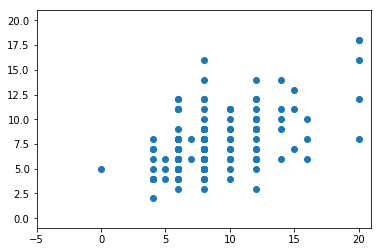

In [204]:
fig, ax = plt.subplots()
ax.scatter(actual, approx)
ax.set_xlim(right=21)
ax.set_ylim(top=21)

In [220]:
i = np.argmax(actual)
outlier = recipes_coll.find_one({'id':recipe_ids[i]})

In [211]:
np.sum(np.array(actual)==0)

1

In [ ]:
print('      Actual servings :', actual)
print('Approximated servings :', approx)

In [229]:
chili_df = pd.DataFrame(columns=common_ingredients, index=recipe_ids).fillna(0)
unknown_servings = []
for recipe in chili_recipes:
    idx = recipe['id']
    servings = recipe['directions']['servings']
    if not servings:
        unknown_servings.append(recipe)
        print('Servings missing')
        continue
    for item in recipe['ingredients']: 
        ing = item['ingredient']
        qty = item['normalized_qty']
        if ing in chili_df.columns:
            #print(ing, qty, servings)
            chili_df.loc[idx, ing] = qty / servings
# Determine approx servings for recipes where it is not specified
for recipe in unknown_servings:
    servings = _approximate_servings(recipe, chili_df)
    recipe['directions']['servings'] = servings
# Apply approx servings to recipes and insert data into dataframe
for recipe in unknown_servings:
    servings = recipe['directions']['servings']
    for item in recipe['ingredients']: 
        ing = item['ingredient']
        qty = item['normalized_qty']
        if ing in chili_df.columns:
            chili_df.loc[idx, ing] = qty / servings
chili_df

,chili powder,onion,tomato,cumin,garlic,beef,salt,oregano,kidney beans,green bell pepper,...,beef stew meat,butter beans,lemon juice,chipotle chile powder,corn chip,chile pepper,beef bouillon,strong coffee,chicken meat,vegetable protein
214843,0.083333,2.000000,3.333333,0.020833,0.083333,3.333333,0.041667,0.000000,0.000000,1.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26462,0.125000,2.000000,0.000000,0.020833,0.000000,4.000000,0.000000,0.000000,1.875000,0.750000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15386,0.178571,1.142857,0.000000,0.000000,0.000000,2.285714,0.047619,0.000000,2.142857,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16188,0.125000,2.000000,1.208333,0.000000,0.416667,4.000000,0.000000,0.000000,3.750000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8835,0.100000,1.600000,2.900000,0.033333,0.200000,0.000000,0.008333,0.033333,3.800000,1.200000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13067,0.166667,0.000000,0.000000,0.027778,0.000000,2.666667,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24406,0.000000,1.333333,1.666667,0.000000,0.000000,5.333333,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23118,0.166667,1.333333,0.000000,0.000000,0.083333,4.000000,0.000000,0.013889,2.500000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15868,0.166667,1.333333,2.666667,0.083333,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
80760,0.416667,1.333333,0.000000,0.055556,0.250000,6.666667,0.000000,0.055556,2.500000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [241]:
model = Sequential()
model.add(Dense(20,  activation='relu', input_shape=(196,)))
#model.add(Dense(10,  activation='relu'))
model.add(Dense(2,    activation='linear', name="bottleneck"))
#model.add(Dense(10,  activation='relu'))
model.add(Dense(20,  activation='relu'))
model.add(Dense(196,  activation='linear'))
model.compile(loss='mean_squared_error', optimizer = 'adam')

In [231]:
X = chili_df.values

In [232]:
means = np.mean(chili_df, axis=0)
stds = np.std(chili_df, axis=0)

In [233]:
chili_scaled = (chili_df - means) / stds

In [234]:
X_scaled = chili_scaled.values

In [253]:
history = model.fit(X_scaled, X_scaled, batch_size=60, epochs=10000, verbose=None)

In [238]:
encoder = Model(model.input, model.get_layer('bottleneck').output)
z_enc = encoder.predict(X_scaled)  # bottleneck representation
r_enc = model.predict(X_scaled)        # reconstruction

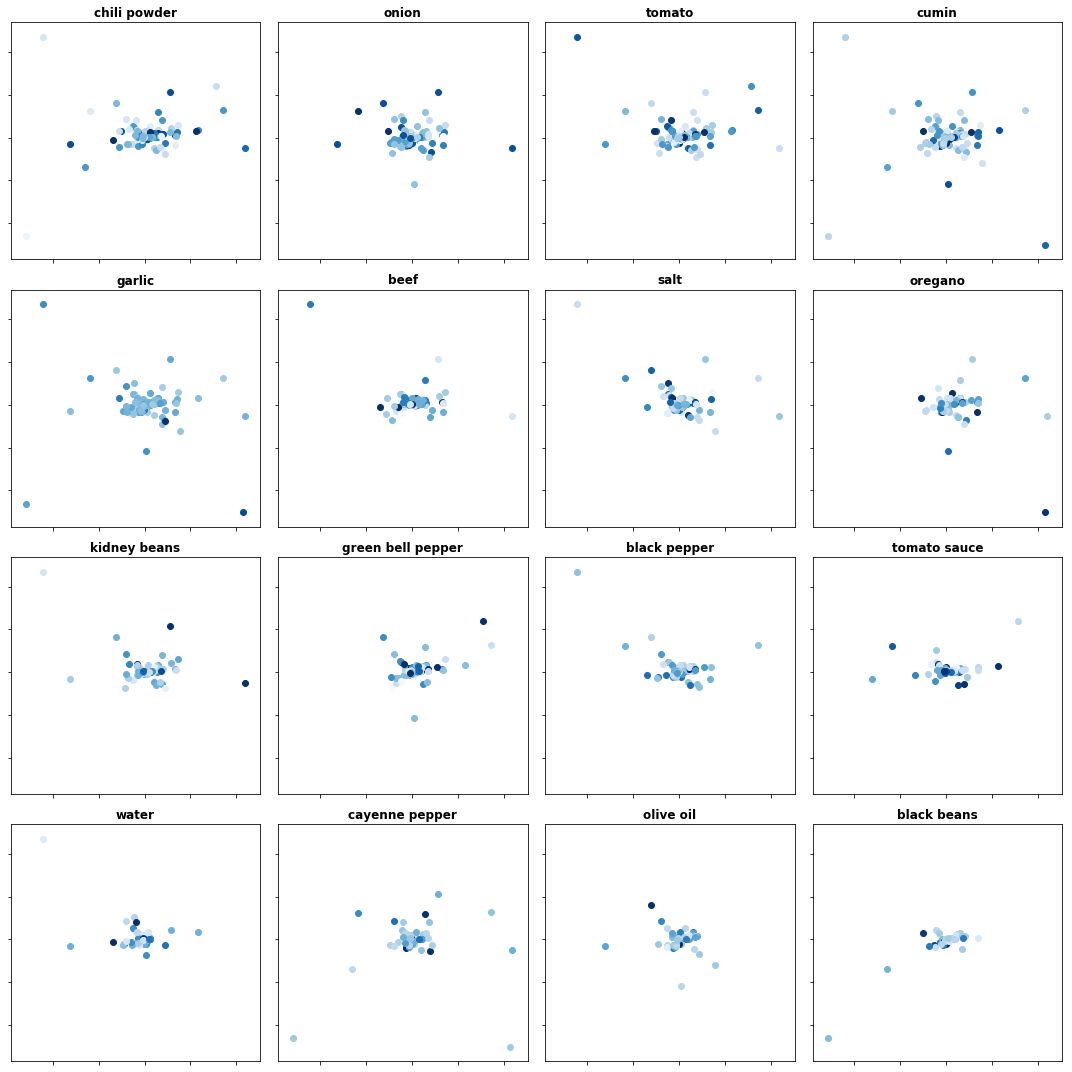

In [256]:
encoder = Model(model.input, model.get_layer('bottleneck').output)
z_enc = encoder.predict(X_scaled)  # bottleneck representation

fig, axs = plt.subplots(4, 4,figsize=(15, 15), sharex=True, sharey=True)
for i, ax in enumerate(axs.flatten()):
    ing = chili_df.columns[i]
    alpha= (chili_df[ing] != 0).astype(float).values
    mean_ing = np.mean(chili_df[chili_df[ing]!=0][ing])
    std_ing = np.std(chili_df[chili_df[ing]!=0][ing])
    color = [cm.Blues((val-(mean_ing)) / (3*std_ing) + 0.5) for val in chili_df[ing]]
    for j in range(len(z_enc)):
        z0 = z_enc[j, 0]
        z1 = z_enc[j, 1]
        ax.scatter(z0, z1, color=color[j], alpha=alpha[j])
    ax.set_title(ing, fontweight='bold')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
fig.tight_layout()

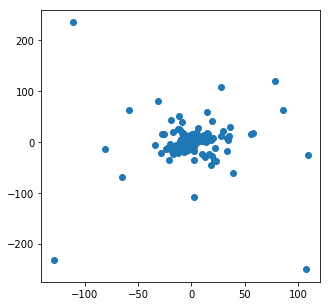

In [254]:
encoder = Model(model.input, model.get_layer('bottleneck').output)
z_enc = encoder.predict(X_scaled)

fig, ax = plt.subplots(figsize=(5, 5))
z0 = z_enc[:, 0]
z1 = z_enc[:, 1]
ax.scatter(z0, z1)

In [252]:
i = np.argmax(z1)
print(i)
recipes_coll.find_one({'id':recipe_ids[i]})


94


{'_id': ObjectId('5ca53ff0c6d0b0083247a97c'),
 'id': 45942,
 'name': 'Fusion Chili',
 'href': 'https://www.allrecipes.com/recipe/45942/fusion-chili/',
 'category': {'lvl_1': 'Soups, Stews and Chili',
  'lvl_2': 'Chili',
  'lvl_3': 'Pork Chili'},
 'rating_info': None,
 'submitter_info': {'id': 165059,
  'name': 'LONBINDER',
  'followers': 11,
  'href': 'https://www.allrecipes.com/cook/165059/'},
 'ingredients': [{'quantity': 10.0,
   'units': 'each',
   'ingredient': 'ancho chile',
   'normalized_qty': 10.0},
  {'quantity': 0.5,
   'units': 'cup',
   'ingredient': 'water',
   'normalized_qty': 4.0},
  {'quantity': 0.25,
   'units': 'cup',
   'ingredient': 'white wine vinegar',
   'normalized_qty': 2.0},
  {'quantity': 3.0,
   'units': 'pound',
   'ingredient': 'italian sausage casing',
   'normalized_qty': 48.0},
  {'quantity': 3.0,
   'units': 'pound',
   'ingredient': 'beef',
   'normalized_qty': 48.0},
  {'quantity': 1.0,
   'units': 'each',
   'ingredient': 'white onion',
   'normal

In [142]:
cm.jet()

(0.9456327985739753, 0.029774872912127992, 0.0, 1.0)

In [145]:
ing = 'beef'
mean_ing = np.mean(chili_df[chili_df[ing]!=0][ing])
std_ing = np.std(chili_df[chili_df[ing]!=0][ing])
color = [(val-(mean_ing)) / (3*std_ing) + 0.5 for val in chili_df[ing]]
print('Max color :', max(color))
print('Min color :', min(color))

Max color : 2.6071414878357806
Min color : -0.055845748546449414
